In [74]:
import pandas as pd
import os
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import string
import time

In [2]:
repertoireCourant = os.getcwd()

In [3]:
data = pd.read_csv(os.path.join(os.path.dirname(repertoireCourant), 'QueryResults_2017.csv'))

<H3>Nettoyage de la colonne Tags</H3>

In [4]:
data.head(2)

,CreationDate,ViewCount,Title,Body,Tags
0,2017-01-12 01:57:22,3143,Spring boot project failing with NoSuchMethodE...,"<p>I have a simple Spring Boot project, I have...",<tomcat><spring-boot>
1,2017-01-12 02:42:09,14227,How to display local image in markdown,"<p>I try the following in markdown, but seems ...",<markdown>


In [5]:
"Nombre de question en 2017: {}".format(len(data))

'Nombre de question en 2017: 18997'

In [6]:
def nettoyageTags(chaineCaractere):
    nlleChaineCaractere = chaineCaractere.replace("><", ",")
    nlleChaineCaractere = nlleChaineCaractere.replace("<", "")
    nlleChaineCaractere = nlleChaineCaractere.replace(">", "")
    return nlleChaineCaractere

In [7]:
data["Tags"] = data["Tags"].apply(nettoyageTags)

<H3>Analyse des tags</H3>

In [8]:
#analyse de la fréquence des tags
frequence_tags = {}
for i, row in data.iterrows():
    for tag in row["Tags"].split(","):
        reponse = frequence_tags.get(tag, -1)
        if reponse == -1:
            frequence_tags[tag] = 1
        else:
            frequence_tags[tag] += 1

In [9]:
"Nombre de tags différents: {}".format(len(frequence_tags))

'Nombre de tags différents: 6049'

In [10]:
tags = []
freq = []
for k, v in frequence_tags.items():
    tags.append(k)
    freq.append(v)
df_tags_freq  = pd.DataFrame({"Tag": tags, "freq": freq})

In [11]:
df_tags_freq = df_tags_freq.sort_values('freq', ascending = False)
df_tags_freq['%'] = df_tags_freq['freq'] / df_tags_freq['freq'].sum() * 100
df_tags_freq['%cumule'] = df_tags_freq['%'].cumsum()

Text(0.5, 1.0, 'Listes des 50 tags les plus cités en 2017')

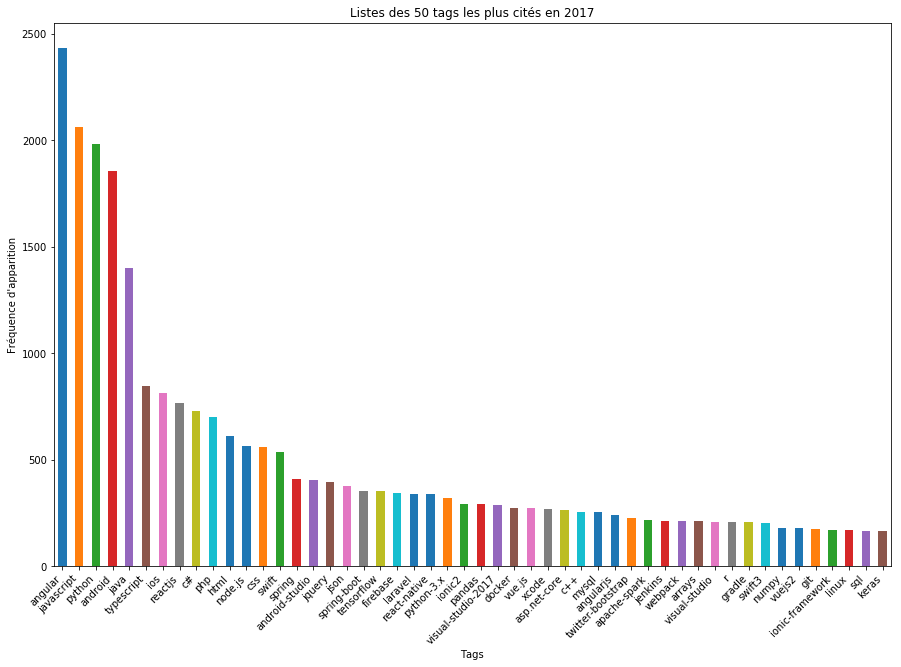

In [12]:
plt.figure(figsize = (15, 10))
df_tags_freq.iloc[:50]['freq'].plot(kind = "bar")
plt.xticks(range(len(df_tags_freq.iloc[:50])), list(df_tags_freq.iloc[:50]['Tag']), rotation = 45, horizontalalignment='right')
plt.xlabel("Tags")
plt.ylabel("Fréquence d'apparition")
plt.title("Listes des 50 tags les plus cités en 2017")

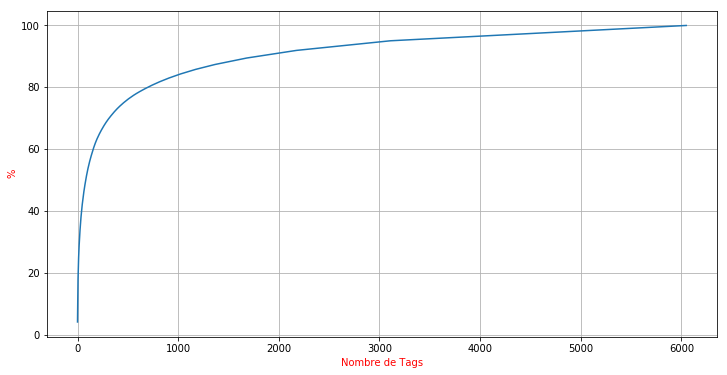

In [13]:
plt.figure(figsize = (12, 6))
plt.plot(range(len(df_tags_freq)), df_tags_freq['%cumule'])
plt.xlabel("Nombre de Tags", color = "red")
plt.ylabel("%", color = "red")
plt.grid()

In [14]:
quantile = df_tags_freq['freq'].quantile([i / 100 for i in range(10, 100, 1)])
df_quantile = pd.DataFrame({"freq": list(quantile)}, index = quantile.index)
df_quantile["% apparition"] = df_quantile['freq'] / len(data) * 100

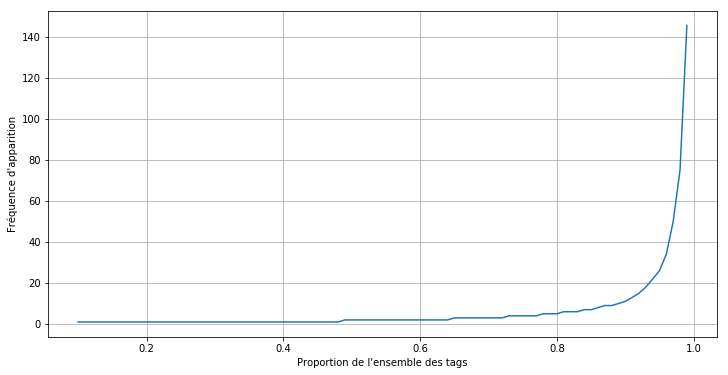

In [15]:
plt.figure(figsize = (12, 6))
plt.plot(df_quantile.index, df_quantile["freq"])
plt.xlabel("Proportion de l'ensemble des tags")
plt.ylabel("Fréquence d'apparition")
plt.grid()

In [16]:
for i, row in df_quantile.iterrows():
    print(i,"\t", row['freq'], "\t", row['% apparition'])

0.1 	 1.0 	 0.005263989050902774
0.11 	 1.0 	 0.005263989050902774
0.12 	 1.0 	 0.005263989050902774
0.13 	 1.0 	 0.005263989050902774
0.14 	 1.0 	 0.005263989050902774
0.15 	 1.0 	 0.005263989050902774
0.16 	 1.0 	 0.005263989050902774
0.17 	 1.0 	 0.005263989050902774
0.18 	 1.0 	 0.005263989050902774
0.19 	 1.0 	 0.005263989050902774
0.2 	 1.0 	 0.005263989050902774
0.21 	 1.0 	 0.005263989050902774
0.22 	 1.0 	 0.005263989050902774
0.23 	 1.0 	 0.005263989050902774
0.24 	 1.0 	 0.005263989050902774
0.25 	 1.0 	 0.005263989050902774
0.26 	 1.0 	 0.005263989050902774
0.27 	 1.0 	 0.005263989050902774
0.28 	 1.0 	 0.005263989050902774
0.29 	 1.0 	 0.005263989050902774
0.3 	 1.0 	 0.005263989050902774
0.31 	 1.0 	 0.005263989050902774
0.32 	 1.0 	 0.005263989050902774
0.33 	 1.0 	 0.005263989050902774
0.34 	 1.0 	 0.005263989050902774
0.35 	 1.0 	 0.005263989050902774
0.36 	 1.0 	 0.005263989050902774
0.37 	 1.0 	 0.005263989050902774
0.38 	 1.0 	 0.005263989050902774
0.39 	 1.0 	 0.00

On constate qu'une très forte proportion des tags apparaissent très peu au regard du nombre de question:
90 % des tags (5444) apparaisent moins de 11 fois sur une base de donnée comportant 18 997 questions
--> Supression des tags figurant moins de 11 fois: si la question n'a plus de tags après suppression alors la question est supprimée

In [17]:
def tagsCleaned(tags, seuil):
    tags2 = []
    for tag in tags.split(","):
        if frequence_tags[tag] >= seuil:
            tags2.append(tag)
    if len(tags2) > 1:
        return ",".join(tags2)
    else:
        return np.nan

In [18]:
data['Tags cleaned'] = data['Tags'].apply(lambda x: tagsCleaned(x, 11))

In [19]:
#Nombre de question restante
"{} % de la base de donnée est conservée après nettoyage des Tags".format(round(len(data[data["Tags cleaned"].notnull()]) / len(data) * 100), 2)

'79 % de la base de donnée est conservée après nettoyage des Tags'

In [20]:
data = data[data["Tags cleaned"].notnull()]

<H3>Analyse du corps des questions</H3>

In [21]:
#Proportion du code versus la question
listeNbreCaracteresBody = []
listeNbreCaracteresCode = []
for i, row in data.iterrows():
    soup = BeautifulSoup(row['Body'])
    codes = soup.find_all("code")
    nbrCarBody = len(row['Body'])
    nbrCarCode = 0
    for code in codes:
        nbrCarCode += len(code.text)
    listeNbreCaracteresBody.append(nbrCarBody)
    listeNbreCaracteresCode.append(nbrCarCode)

In [22]:
statNbreCaract = pd.DataFrame(data = {"nbre caracteres Body": listeNbreCaracteresBody, "nbre caracteres code": listeNbreCaracteresCode}, index = data.index)

In [23]:
statNbreCaract['Proportion'] = round((statNbreCaract['nbre caracteres code'] / statNbreCaract['nbre caracteres Body']) * 100, 2)

In [24]:
statNbreCaract.describe()

,nbre caracteres Body,nbre caracteres code,Proportion
count,14984.000000,14984.000000,14984.000000
mean,1710.325414,1002.015550,39.280817
std,2346.613678,2122.711846,28.511986
min,53.000000,0.000000,0.000000
25%,593.000000,78.000000,12.697500
50%,1039.000000,362.000000,39.630000
75%,1912.000000,1037.000000,62.760000
max,30033.000000,28824.000000,99.760000


In [25]:
def nettoyage_texte(texte):
    for motif in [r"\n", r'<code>.*?<\/code>', r"<.*?>", r"\r", r"(\w+\/)+[\w+\.]+", r'https?://[\S]+', r"(\w+\.)+\w+", r"\$\w+", r'\b(\w)\1+\b', r"  +", r"\b[0-9]+\b"]:
        while re.search(motif, texte):
            texte = re.sub(motif, " ", texte)
    return texte

In [26]:
data['Title_Body'] = data[["Title", "Body"]].apply(lambda x: nettoyage_texte(x['Title'] + " " + x['Body']), axis = 1)

In [27]:
data['nbre_mot_title_body'] = data['Title_Body'].apply(lambda x: len(x.split()))

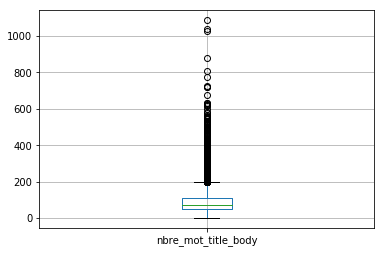

In [28]:
data[['nbre_mot_title_body']].boxplot()

In [29]:
data['nbre_mot_title_body'].quantile([0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

0.001     13.00
0.010     21.00
0.050     31.00
0.250     52.00
0.500     74.00
0.750    111.00
0.950    204.00
0.990    333.17
Name: nbre_mot_title_body, dtype: float64

(-50, 750)

C:\Users\Lies\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


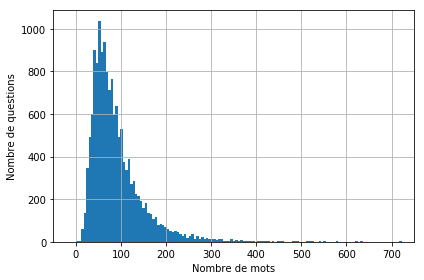

In [30]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(data['nbre_mot_title_body'], bins= 200)
plt.grid()
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de questions")
plt.xlim(-50, 750)

<h2>TOKENIZATION</h2>

In [31]:
# Il s'agit de "casser" le texte en conservant les mots et d'obtenir ainsi un "sac de mots" (bag of words)

In [32]:
from nltk.tokenize import RegexpTokenizer
treebank_wt = nltk.TreebankWordTokenizer()

In [33]:
%%time
texte_token = []
for question in list(data['Title_Body']):
    texte_token.append(treebank_wt.tokenize(question))

Wall time: 4.28 s


<H3>SUPPRESSION DE MOTS CONSTITUE UNIQUEMENT DE CHIFFRE ET TRANSFORMATION EN MINUSCULE DES MOTS</H3>

In [34]:
%%time
for i, question in enumerate(texte_token):
    q = []
    for mot in question:
        if re.match(r"\d", mot) is None:
            q.append(mot.lower())
    texte_token[i] = q

Wall time: 1.49 s


<h3>SUPPRESSION DES PONCTUATIONS, DES MOTS AVEC _ ET DES MOTS VIDES</h3>

In [35]:
stopwords_english = set(ENGLISH_STOP_WORDS)

In [36]:
#On nettoie chaque document "tokenisé" des ponctuations et des mots vides

In [37]:
%%time
ponctuations = string.punctuation
for i in range(len(texte_token)):
    x = [m for m in texte_token[i] if not (m in ponctuations)]
    expression = re.compile(r"[a-zA-Z0-9]+")
    for j in range(len(x)):
        if expression.search(x[j]):
            x[j] = expression.search(x[j]).group(0)
        else:
            x[j] = ''
    expression = re.compile(r"([a-zA-Z]+_)+[a-zA-Z]*")
    for j in range(len(x)):
        if expression.search(x[j]):
            x[j] = ''
    x = [m for m in x if not (m in stopwords_english)]
    texte_token[i] = [m for m in x if not(len(m) <= 1)]

Wall time: 2.29 s


<h3>LEMMATISATION</H3>

In [38]:
#Normalisation des mots en ne conservant que la racine des mots

In [39]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

In [40]:
%%time
for i in range(len(texte_token)):
    texte_token[i] = [wnl.lemmatize(m) for m in texte_token[i]]

Wall time: 3.51 s


<h3>Reconstitution des question à partir du "sac de mots</h3>

In [41]:
texte_token2 = []
for i in range(len(texte_token)):
    texte_token2.append(" ".join(texte_token[i]))

data2 = pd.DataFrame({'Body': texte_token2}, index = data.index)

In [42]:
data['Title_Body_cleaned'] = data2['Body']

In [43]:
data = data[['CreationDate', 'ViewCount', 'Title', 'Body','Title_Body', 'Title_Body_cleaned', 'Tags', 'Tags cleaned', 'nbre_mot_title_body']]

<H2>CREATION JEU ENTRAINEMENT ET JEU TEST</H2>

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
Quest_train, Quest_test, Tags_train, Tags_test = train_test_split(data[['Title_Body_cleaned']], data[['Tags cleaned']])

In [46]:
dictionnaire_tags_train = []
for i, row in Tags_train.iterrows():
    for m in row["Tags cleaned"].split(","):
        dictionnaire_tags_train.append(m)
dictionnaire_tags_train = list(set(dictionnaire_tags_train))
dictionnaire_tags_train.sort()

In [47]:
len(dictionnaire_tags_train)

647

<h3>Création d'une matrice avec en ligne le corpus (question) d'un jeu d'entrainement et en colonne les tags<h3>

In [48]:
%%time
#Instructions servant à mettre dans l'ordre alphabétique les tags
for i, row in Tags_train.iterrows():
    liste = row["Tags cleaned"].split(",")
    liste.sort()
    Tags_train["Tags cleaned"].loc[i] = ",".join(liste)

Wall time: 4.3 s


In [49]:
%%time
#/!\ il est indispensable de classer en ordre (croissant ou décrossant les tags avant d'utiliser cette méthode)
Tags_train_vect = Tags_train['Tags cleaned'].str.get_dummies(sep = ",")

Wall time: 18.8 s


<h3>Création d'une matrice avec en ligne le corpus (question) d'un jeu de test et en colonne les tags<h3>

In [93]:
%%time
#Instructions servant à mettre dans l'ordre alphabétique les tags
for i, row in Tags_test.iterrows():
    liste = row["Tags cleaned"].split(",")
    liste.sort()
    Tags_test["Tags cleaned"].loc[i] = ",".join(liste)

Wall time: 1.15 s


In [94]:
%%time
#/!\ il est indispensable de classer en ordre (croissant ou décrossant les tags avant d'utiliser cette méthode)
Tags_test_vect = Tags_test['Tags cleaned'].str.get_dummies(sep = ",")

Wall time: 6.36 s


<h2>COUNT VECTORISOR</h2>

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
#vect = CountVectorizer(min_df = 0.02, max_df = 0.98)
vect = CountVectorizer(min_df = 0.003, max_df = 0.997)

In [51]:
vect.fit(Quest_train['Title_Body_cleaned'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.997, max_features=None, min_df=0.003,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [52]:
dictionnaire = vect.get_feature_names()

In [53]:
len(dictionnaire)

1365

In [54]:
Quest_train_vect = vect.transform(Quest_train['Title_Body_cleaned'])

In [55]:
Quest_test_vect = vect.transform(Quest_test['Title_Body_cleaned'])

In [56]:
#Création d'une matrice creuse avec en colonnes le dictionnaire de mots
#en ligne le CORPUS
#
Quest_train_vect

<11238x1365 sparse matrix of type '<class 'numpy.int64'>'
	with 268751 stored elements in Compressed Sparse Row format>

In [57]:
for k in range(Quest_train_vect.shape[0]):
    print("Document " + str(k))
    for i, freq in enumerate(Quest_train_vect.toarray()[k]):
        if freq > 0:
            print("{} : {}".format(dictionnaire[i], freq))
    print()
    if k == 5:
        break

Document 0
allow : 1
api : 1
doe : 1
latest : 1
possible : 1
pull : 2
specific : 2
use : 2

Document 1
access : 1
angular : 1
click : 2
close : 8
closed : 1
come : 1
component : 1
content : 1
documentation : 1
doe : 1
example : 2
fine : 1
function : 2
idea : 1
imported : 1
importing : 1
included : 1
inside : 1
like : 1
mentioned : 1
modal : 5
ng : 3
note : 1
open : 1
provided : 1
rid : 1
shown : 1
tried : 1
trying : 1
undefined : 1
want : 2
website : 1
weird : 1
work : 2
wrong : 1

Document 2
application : 1
building : 1
code : 2
console : 1
current : 1
currently : 1
date : 2
display : 1
error : 1
extra : 1
feature : 1
got : 1
implement : 1
know : 1
label : 1
live : 2
new : 1
notice : 1
old : 1
static : 1
tested : 1
time : 3
tried : 1
use : 1
using : 1
worked : 1

Document 3
app : 1
controller : 5
create : 1
easy : 1
failed : 1
function : 1
method : 1
navigation : 1
opened : 1
root : 1
swift : 1
time : 1
tried : 1
user : 1
various : 1
view : 4
want : 3
way : 2

Document 4
best : 1
clas

<H2>LATENT DIRICHLET ALLOCATION</H2>

Cette méthode tente de regrouper les documents contenant des sous-ensemble de mots communs

In [58]:
from sklearn.decomposition import LatentDirichletAllocation as lda

In [60]:
nbre_sujet = 1200

In [61]:
#model = lda(n_components = nbre_sujet, max_iter = 20)
model = lda(n_components = nbre_sujet)

In [62]:
%%time
model.fit(Quest_train_vect)

Wall time: 5min 9s


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=1200, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [63]:
#Nous affichons pour chacun des 10 sujets
#les 10 mots les plus représentatifs
for i in range(nbre_sujet):
    df99 = pd.DataFrame({"mot": dictionnaire, "coef": model.components_[i]})
    print(i)
    print(df99.sort_values("coef", ascending= False)[:10])
    print()

0
            mot        coef
509        give  428.065849
1245      tried   54.991513
478   following   43.489778
1291      using   41.430098
1341       work   34.793040
1351      wrong   19.824742
1251     trying   17.623379
836      output   14.399590
654        know   13.736293
546        help    7.695772

1
          mot        coef
49        apk  141.000774
404     error   16.785565
36    android   13.601999
1304  version   12.294117
140     build   10.663322
790       new   10.026032
879      play    6.363501
996   release    6.344250
518    google    4.081957
17      added    2.312337

2
              mot        coef
798           non  162.393490
863   performance   67.164834
354           doe   24.048656
1286          use   23.755762
956      question   16.584982
654          know   10.059620
1263   understand    8.831336
705       looking    8.245741
1071       second    7.300542
1190         sure    6.819290

3
             mot        coef
674        level  155.545170
1263  u

             mot       coef
727       master  12.972102
790          new   5.130763
825         open   3.966883
1318        want   3.068016
999       remote   3.000833
541       having   2.552185
534      handler   2.410413
0           able   2.215656
1341        work   2.156180
234   connecting   2.000833

64
            mot        coef
744   mentioned  128.729691
900      posted   41.046492
1245      tried    8.950773
195        code    8.278456
478   following    4.751661
691       local    3.322751
448         far    2.802056
1322        way    2.678438
354         doe    1.556772
457        file    1.445250

65
            mot        coef
1357        xml  184.574861
404       error   67.331786
457        file   57.380870
195        code   10.301971
478   following    9.976327
679        line    8.832606
1291      using    6.607277
36      android    4.357249
784        need    3.760343
280   currently    2.645922

66
             mot       coef
1263  understand  11.307817
1207    

566             http  1.841516

135
              mot       coef
866         phone  86.971336
1095        share  72.622924
50            app  22.998883
1291        using  16.406640
1318         want  11.985419
610     installed  10.834207
825          open  10.379930
1245        tried   9.613597
56    application   9.607213
677          like   9.580064

136
             mot      coef
1092     setting  2.985852
125        blank  2.000833
1302          ve  1.977075
1322         way  1.768976
1287        used  1.150411
647         just  1.108975
809       number  1.000833
702       longer  1.000833
92     available  1.000833
332   difference  1.000833

137
         mot        coef
1336      wo  128.584510
1341    work   15.696026
572     idea    6.619456
647     just    6.405966
1245   tried    5.642067
1351   wrong    4.012501
715     make    3.222144
354      doe    2.518489
748   method    2.077064
404    error    1.479182

138
            mot       coef
1055        saw  93.240508
997 

1286          use   14.242439

213
            mot        coef
1140     spring  347.919489
130        boot  291.641040
932     project   41.113482
1322        way   19.034420
280   currently   14.736584
1044    running   12.657342
1234     tomcat   10.877917
1302         ve    7.493130
1217     thanks    7.478069
1251     trying    6.921053

214
            mot        coef
442      failed  325.311242
404       error  245.858591
419   execution  106.757477
50          app   70.537269
1203       task   36.733619
36      android   31.682526
457        file   23.339869
140       build   21.797446
506     getting   18.080618
1171     studio   16.469681

215
             mot      coef
457         file  6.000833
259         core  4.000833
299      default  3.000833
37       angular  3.000833
1245       tried  3.000833
250   controller  3.000833
856         path  3.000833
1030      return  2.000833
140        build  2.000833
1087       serve  2.000833

216
            mot       coef
498       

294
            mot       coef
769       month  65.716676
1361  yesterday  41.551156
404       error  11.322941
463        fine  10.375265
1302         ve   7.306874
1219      thing   7.167730
1344    working   7.086719
331         did   5.751085
654        know   5.655653
50          app   3.684156

295
            mot       coef
118         big  61.888283
43       answer   2.093409
1318       want   0.578155
1291      using   0.539963
147          ca   0.522820
1289       user   0.313580
107   basically   0.159865
269      create   0.066037
1141        sql   0.054996
1088     server   0.029103

296
           mot       coef
1293        v4  80.114399
1291     using  17.913078
963      react  11.984234
1039    router   8.471841
841       page   8.192401
50         app   5.645278
1341      work   4.800769
781   navigate   4.572907
1190      sure   4.521569
0         able   3.858192

297
            mot        coef
1057     saying  127.899164
404       error    9.774181
969      really  

              mot        coef
1000       remove  390.370566
1031     returned  124.453218
1318         want   44.703118
195          code   44.205882
1245        tried   28.711709
748        method   19.204332
404         error   18.339356
1322          way   13.858757
56    application   10.523743
677          like    9.920999

378
             mot       coef
1169  struggling  59.074726
790          new   6.552100
1027      result   6.333722
1251      trying   4.040213
147           ca   2.930368
546         help   1.785095
1012     request   1.085532
1250         try   0.769539
811       object   0.533883
1322         way   0.483489

379
          mot        coef
398     entry  124.634157
496      game   40.231276
546      help   19.619431
269    create   15.035554
147        ca   14.144291
1091      set    9.042309
920   problem    6.784431
1318     want    5.584305
331       did    4.697259
784      need    3.615169

380
              mot        coef
148         cache  141.136454
8

           mot      coef
1030    return  5.000833
388   encoding  4.000833
279    current  3.000833
808       null  3.000833
1064    script  3.000833
677       like  2.783918
404      error  2.733516
457       file  2.711793
825       open  2.000833
65    argument  2.000833

447
           mot       coef
1079      self  48.000833
1001   removed   2.000833
270    created   1.778068
572       idea   1.691647
245   contains   1.314518
9      achieve   1.170027
784       need   1.090664
1322       way   1.073516
1071    second   1.045138
1106    signed   0.772116

448
              mot        coef
799        normal  105.388249
1286          use   16.338580
195          code    8.140406
56    application    6.883347
956      question    6.859238
546          help    5.824148
1092      setting    5.157577
715          make    5.012598
1245        tried    4.997937
647          just    4.471211

449
             mot      coef
1071      second  8.885028
1243  transition  5.916833
1263  underst

            mot       coef
1352      wrote  94.032740
195        code  50.044814
849        part  40.531140
478   following  11.713458
331         did   9.450413
1227       time   8.794758
1217     thanks   6.217135
1286        use   4.656578
1274     update   4.534514
572        idea   3.854810

525
             mot        coef
243    container  330.352947
553         high   53.578818
784         need   25.493896
1044     running   16.808783
1251      trying   13.961043
354          doe   13.401751
1341        work   12.041365
3         access    7.577758
0           able    5.354840
351   dockerfile    5.298787

526
             mot       coef
440         fact  61.992132
404        error   4.350506
566         http   4.204198
508       github   4.077457
1044     running   3.582002
631        issue   3.326788
969       really   3.295631
920      problem   2.936026
1011  repository   2.921810
1245       tried   2.666564

527
           mot       coef
1360       yes  95.892789
3       a

          mot       coef
794     nginx  93.000833
1088   server  29.433690
1341     work   4.607471
1012  request   4.136585
1043      run   3.698721
1227     time   3.211038
1245    tried   2.223429
784      need   2.160534
677      like   1.433013
1109   simple   1.026101

611
         mot        coef
1173   style  238.577676
1157  status  232.101594
1091     set   26.836659
1341    work   17.185214
463     fine   12.508731
195     code   12.015231
1245   tried   11.826525
168   change   10.353577
677     like    9.760571
102      bar    9.760469

612
            mot       coef
752   migration  74.939985
1322        way   2.972354
715        make   2.916913
195        code   2.605660
331         did   2.467631
647        just   2.399755
673         let   1.991664
478   following   1.891220
1250        try   1.872702
1121   solution   1.854515

613
               mot        coef
528          guess  116.443839
1286           use    3.759151
1245         tried    1.513810
1134  specific

          mot       coef
519   googled  48.953690
1206  telling  29.347602
404     error   9.267365
354       doe   8.487579
1251   trying   5.776580
1217   thanks   3.030909
23    advance   2.960653
1351    wrong   2.321804
47        api   2.207388
1190     sure   2.146775

704
              mot        coef
217      complete  138.705936
1044      running    8.409996
1341         work    5.208988
1043          run    5.197361
56    application    4.683259
705       looking    3.576885
463          fine    2.643311
478     following    2.620268
354           doe    1.842210
376          edit    1.755528

705
                 mot       coef
83         attribute  62.551225
84    attributeerror  52.000833
811           object  38.829349
404            error  36.823858
195             code  33.305659
1291           using  15.069586
920          problem   7.933441
1250             try   7.653284
766           module   7.220176
478        following   7.195981

706
           mot       coef
13

             mot       coef
924      produce  92.307611
406   especially  24.986789
195         code  15.282898
1027      result  11.457146
412      example   9.295079
478    following   7.162482
920      problem   6.848205
517         good   6.299640
679         line   4.351095
333    different   3.165229

794
           mot      coef
50         app  5.000110
683       list  4.904835
195       code  3.925027
277        csv  3.000833
376       edit  2.998304
677       like  2.826209
1031  returned  2.000833
714       main  2.000833
647       just  2.000833
1251    trying  2.000833

795
            mot        coef
448         far  245.061703
280   currently   20.471706
1251     trying   17.922361
390         end   14.873673
195        code    8.344262
614     instead    8.163929
269      create    5.022164
1287       used    4.694182
841        page    3.154236
1291      using    2.741921

796
           mot        coef
170   changing  205.952528
168     change   47.906317
1322       wa

            mot      coef
543      header  3.000833
354         doe  2.679739
700       login  2.000833
1289       user  1.995926
1302         ve  1.980837
1286        use  1.955441
333   different  1.021604
696         log  1.000833
1351      wrong  1.000833
342     display  1.000833

858
            mot       coef
961      random  70.017718
1302         ve   7.178057
1091        set   7.036099
1227       time   6.162922
1034      right   3.698338
1344    working   3.405354
17        added   3.117181
1119     socket   3.078832
280   currently   2.882072
1322        way   2.475912

859
            mot        coef
1032  returning  102.151149
710        luck   92.971006
101         bad   86.333287
1245      tried   81.178752
1344    working   22.415773
1219      thing   20.295705
404       error   14.873210
1302         ve   11.879779
1351      wrong   11.595969
354         doe   10.948857

860
            mot        coef
128        body  149.690219
824      online  119.365573
654       

18      adding    0.955528

942
         mot      coef
715     make  5.002731
1190    sure  4.920367
784     need  3.058647
677     like  3.018299
50       app  2.974214
147       ca  2.497875
825     open  2.495582
1043     run  2.418323
1160    stop  2.079489
1274  update  2.010975

943
             mot        coef
198        color  345.974575
1091         set   15.117698
1286         use   12.524480
1218       theme   11.027928
412      example   10.411529
1287        used    9.028536
16           add    8.136416
1291       using    7.687143
100   background    7.529806
715         make    7.492921

944
             mot      coef
674        level  3.000833
836       output  2.807034
1291       using  2.531978
1263  understand  2.146841
957        quite  2.088171
74      assigned  2.000833
1236       topic  2.000833
16           add  2.000833
1085  separately  2.000833
790          new  2.000833

945
            mot        coef
867         php  523.397505
434   extension  143.729456


          mot      coef
902   postman  5.960414
342   display  3.000833
867       php  2.000833
1064   script  2.000833
1196      tab  2.000833
0        able  2.000833
1080     send  1.936498
283      data  1.471667
1302       ve  1.051433
168    change  1.000833

1017
         mot       coef
549       hi  86.001453
1116    slow  47.811848
1251  trying  14.727503
1217  thanks  13.682441
790      new  11.363764
1071  second  11.049932
1291   using  10.817839
1318    want  10.436865
356    doing   8.810126
969   really   4.943331

1018
           mot       coef
970     reason  35.300111
390        end   4.742529
47         api   3.953132
676    library   3.285342
664     latest   2.402151
1274    update   2.069590
1322       way   1.608983
956   question   1.594591
1341      work   1.382757
1092   setting   1.226893

1019
           mot        coef
670   learning  166.405659
1242  training   67.708171
412    example   24.546398
1286       use   14.115528
1027    result   13.300195
1291  

           mot        coef
3       access  578.472477
404      error   46.506322
47         api   29.503908
1251    trying   29.270065
1012   request   26.834257
31     allowed   26.636683
543     header   24.132706
1022  resource   22.822239
1291     using   22.548730
354        doe   22.546541

1045
            mot        coef
988     refresh  165.987645
1338  wondering  156.417033
1317        wan   26.999905
1318       want   11.841701
776          na   11.464956
1322        way   11.070962
841        page    8.887694
331         did    3.234885
1216      thank    2.437643
1286        use    1.878100

1046
            mot       coef
113   behaviour  51.418460
425    expected   7.805153
1043        run   4.545516
1108    similar   2.405624
412     example   2.384024
801        note   1.844775
736       maybe   1.483184
13       actual   1.150403
47          api   1.046772
514        goal   1.042447

1047
           mot        coef
500   generate  195.895400
842       pair   51.855540

           mot        coef
738       mean  337.810759
354        doe  137.137212
956   question   17.522580
677       like   10.680047
1291     using    9.227948
647       just    8.587707
1341      work    7.835149
404      error    7.517739
572       idea    7.415604
784       need    4.727490

1109
           mot        coef
453      fetch  164.758576
238   constant   50.938044
47         api   30.445030
1286       use   15.022541
283       data   13.723052
493   function    8.726864
1291     using    8.553639
715       make    8.479670
784       need    8.334585
1297     value    8.150041

1110
            mot      coef
841        page  7.870910
47          api  4.000833
1227       time  3.000833
493    function  3.000833
784        need  2.819943
195        code  2.770460
956    question  2.000833
152      called  2.000833
1117      small  2.000833
419   execution  2.000833

1111
            mot        coef
808        null  307.293824
617     integer   96.341005
1297      value   

            mot       coef
838    overflow  49.950037
404       error   8.067350
1344    working   4.721061
195        code   4.279795
1219      thing   4.203951
47          api   3.789233
920     problem   3.523420
50          app   3.397494
1166     stream   3.051241
92    available   2.389911

1140
          mot        coef
768   mongodb  122.402243
797    nodejs   89.939797
404     error   34.418961
1291    using   31.450927
1251   trying   17.670604
195      code   11.675490
506   getting    8.036461
647      just    7.226203
1304  version    5.017148
1044  running    4.961439

1141
           mot      coef
881       plot  7.653287
679       line  4.461206
843      panda  3.855444
1109    simple  3.275759
283       data  3.085555
1027    result  2.591568
956   question  2.479273
1245     tried  2.058452
1302        ve  2.035208
493   function  2.000833

1142
          mot       coef
1303   verify  62.792764
1213   tested  62.632647
1027   result  24.701803
195      code  13.716341

1194
            mot        coef
846      parent  211.473988
178       child   40.677003
221   component   38.439405
1291      using   17.449164
1322        way   15.573416
354         doe   12.883400
195        code   11.471824
1251     trying   11.379134
631       issue    8.321061
37      angular    8.262293

1195
          mot       coef
893     popup  50.653015
1334   window  15.443040
790       new   9.769587
1318     want   8.535940
269    create   6.622937
572      idea   4.017648
195      code   3.598964
546      help   3.544670
16        add   3.099165
920   problem   1.964089

1196
           mot        coef
583     import  578.999649
457       file  114.440061
1250       try   53.868326
404      error   42.676363
1341      work   30.631946
1291     using   27.013410
932    project   26.728555
312   deployed   23.140907
50         app   20.360337
1287      used   18.282476

1197
            mot       coef
291        deal  42.000224
354         doe   7.481336
572        idea 

<H2>TOPIC MODELING</H2>

In [64]:
#Transformation de la matrice 
#Pour obtenir une matrice question par topic
Quest_topic = model.transform(Quest_train_vect)
Quest_topic_T = Quest_topic.transpose()
Topic_tags = Quest_topic_T.dot(Tags_train_vect.values)

<H3>ETUDE DU TAUX DE PREDICTION</H3>

In [65]:
Quest_topic_test = model.transform(Quest_test_vect)
Quest_tags_test = Quest_topic_test.dot(Topic_tags)
df_Quest_Tags_test = pd.DataFrame(data = Quest_tags_test, columns = list(dictionnaire_tags_train), index = Quest_test.index)

In [66]:
preco_Tags_test = []
preco_Tags_test_coef = []
for i, row in df_Quest_Tags_test.iterrows():
    preco_Tags_test.append(",".join(row.sort_values(ascending = False).index[:5]))
df_preco_Tags_test = pd.DataFrame({"Preco_Tags": preco_Tags_test}, index = Tags_test.index)


In [67]:
df_preco_Tags_test['Tags_cleaned'] = Tags_test['Tags cleaned']

In [68]:
df_preco_Tags_test

,Preco_Tags,Tags_cleaned
8981,"javascript,angular,python,java,android","java,tomcat"
14678,"javascript,angular,php,python,laravel","php,laravel,email"
836,"python,jenkins,javascript,angular,jenkins-pipe...","jenkins,jenkins-pipeline"
6270,"webpack,javascript,reactjs,angular,node.js","node.js,api,reactjs,proxy,request"
1037,"python,javascript,angular,android,jupyter-note...","matplotlib,ipython,jupyter-notebook,jupyter"
13142,"css,angular,html,javascript,css3","angular,angular-cli"
15266,"javascript,angular,date,java,python","sql,oracle"
2438,"java,angular,javascript,python,css","java,maven,sonarqube"
9914,"android,android-fragments,angular,javascript,java","android-layout,layout"
4906,"android,android-fragments,android-studio,java,...","android,android-layout,android-fragments"


In [69]:
def taux_prediction(tags_predict, tags):
    l_predict = set(tags_predict.split(","))
    l = set(tags.split(","))
    tags_communs = l_predict & l
    nbre_tags_communs = len(tags_communs)
    precision = nbre_tags_communs / len(l_predict)
    rappel = nbre_tags_communs / len(l)
    if precision > 1:
        taux = 1
    if rappel > 1:
        rappel = 1
    return tags_communs, nbre_tags_communs, precision, rappel

In [70]:
tags_communs = []
nbre_tags_communs = []
precision = []
rappel = []

for i, row in df_preco_Tags_test.iterrows():
    rep = taux_prediction(row['Preco_Tags'], row['Tags_cleaned'])
    tags_communs.append(rep[0])
    nbre_tags_communs.append(rep[1])
    precision.append(rep[2])
    rappel.append(rep[3])

df_preco_Tags_test['tags_communs'] = tags_communs
df_preco_Tags_test['nbre_tags_communs'] = nbre_tags_communs
df_preco_Tags_test['precision'] = precision
df_preco_Tags_test['rappel'] = rappel

In [71]:
liste_moyennes = []
liste_nbre_sujets = []

In [72]:
print("Precision: {}".format(df_preco_Tags_test["precision"].mean()))
print("Rappel: {}".format(df_preco_Tags_test["rappel"].mean()))
print("Moyenne harmonique: {}".format(2 * (df_preco_Tags_test["precision"].mean() * df_preco_Tags_test["rappel"].mean()) /(df_preco_Tags_test["precision"].mean() + df_preco_Tags_test["rappel"].mean() )))

Precision: 0.25840896956754256
Rappel: 0.45884054102153404
Moyenne harmonique: 0.330619985516081


In [73]:
def recherche_nbre_sujet_optimal(min_nbre_sujets, max_nbre_sujets, pas):
    liste_rappel = []
    liste_precision = []
    liste_nbre_sujets = []
    for i in range(min_nbre_sujets, max_nbre_sujets + 1, pas):
        print(i)
        nbre_sujet = i
        model = lda(n_components = nbre_sujet)
        model.fit(Quest_train_vect)
        Quest_topic = model.transform(Quest_train_vect)
        Quest_topic_T = Quest_topic.transpose()
        Topic_tags = Quest_topic_T.dot(Tags_train_vect.values)
        Quest_topic_test = model.transform(Quest_test_vect)
        Quest_tags_test = Quest_topic_test.dot(Topic_tags)
        df_Quest_Tags_test = pd.DataFrame(data = Quest_tags_test, columns = list(dictionnaire_tags_train), index = Quest_test.index)
        preco_Tags_test = []
        for i, row in df_Quest_Tags_test.iterrows():
            preco_Tags_test.append(",".join(row.sort_values(ascending = False).index[:5]))
        df_preco_Tags_test = pd.DataFrame({"Preco_Tags": preco_Tags_test}, index = Tags_test.index)
        df_preco_Tags_test['Tags_cleaned'] = Tags_test['Tags cleaned']
        tags_communs = []
        nbre_tags_communs = []
        precision = []
        rappel = []

        for i, row in df_preco_Tags_test.iterrows():
            rep = taux_prediction(row['Preco_Tags'], row['Tags_cleaned'])
            tags_communs.append(rep[0])
            nbre_tags_communs.append(rep[1])
            precision.append(rep[2])
            rappel.append(rep[3])

        df_preco_Tags_test['tags_communs'] = tags_communs
        df_preco_Tags_test['nbre_tags_communs'] = nbre_tags_communs
        df_preco_Tags_test['precision'] = precision
        df_preco_Tags_test['rappel'] = rappel
        
        liste_nbre_sujets.append(nbre_sujet)
        liste_rappel.append(df_preco_Tags_test['rappel'].mean())
        liste_precision.append(df_preco_Tags_test['precision'].mean())
        
    return liste_nbre_sujets, liste_rappel, liste_precision

    

In [ ]:
%%time
reponse = recherche_nbre_sujet_optimal(100, 1500, 100)

In [ ]:
len(reponse)

In [ ]:
plt.figure(figsize = (15, 10))
plt.plot(reponse[0], reponse[1])
plt.grid()
plt.xlabel("Nombres de sujets")
plt.ylabel("Moyenne prédiction")
plt.savefig("Courbe precision.png", dpi = 300)

<H2>SVM CLASSIFIER</H2>

In [ ]:
from sklearn.linear_model import SGDClassifier

In [75]:
from sklearn.svm import SVC

In [81]:
Quest_train_vect

<11238x1365 sparse matrix of type '<class 'numpy.int64'>'
	with 268751 stored elements in Compressed Sparse Row format>

In [107]:
rep_predictions = []
tags_predictions = []
tags_absent_dans_test = []
liste_tags = Tags_train_vect.columns

In [109]:
%%time
for i in range(len(liste_tags)):
    #Choix du tags
    tag = liste_tags[i]
    print("*" * 30)
    print(i)
    if i == 5:
        break
    try:
        Tags_train_vect_0 = Tags_train_vect[tag]
        Tags_test_vect_0 = Tags_test_vect[tag]
        print("*" * 30)
        print(tag)
        svm_0 = SVC(kernel = "rbf", C = 10, gamma = 0.1).fit(Quest_train_vect, Tags_train_vect_0)
        tags_predictions.append(tag)
        rep_preditions.append(list(svm.predict(Quest_test_vect)))
    except:
        print("*" * 30)
        print(tag)
        tags_absent_dans_test.append(tag)
        print("Le tag {} n'est pas présent dans Test".format(tag))

******************************
0
******************************
.htaccess
******************************
.htaccess
Le tag .htaccess n'est pas présent dans Test
******************************
1
******************************
.net
******************************
.net
Le tag .net n'est pas présent dans Test
******************************
2
******************************
.net-core
******************************
.net-core
Le tag .net-core n'est pas présent dans Test
******************************
3
******************************
.net-standard
******************************
.net-standard
Le tag .net-standard n'est pas présent dans Test
******************************
4
******************************
adb
******************************
adb
Le tag adb n'est pas présent dans Test
******************************
5
Wall time: 3min 56s


In [102]:
%%time
svm_0 = SVC(kernel = "rbf", C = 10, gamma = 0.1).fit(Quest_train_vect, Tags_train_vect_0)

Wall time: 38.1 s


In [ ]:
tags_predictions.append(tag)
rep_preditions.append(list(svm.predict(Quest_test_vect)))

In [104]:
%%time
print("Precision on training set: {}".format(svm.score(Quest_train_vect, Tags_train_vect_0)))
print("Precision on test set: {}".format(svm.score(Quest_test_vect, Tags_test_vect_0)))

Precision on training set: 1.0
Precision on test set: 0.9981313400961025
Wall time: 28.5 s


In [106]:
%%time
list(svm.predict(Quest_test_vect))

Wall time: 7.18 s


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
